In [ ]:
import re
import numpy as np
from scipy.special import erf
from dataclasses import dataclass
import matplotlib.pyplot as plt
from tqdm import tqdm
from snapgene_reader import snapgene_file_to_dict
from numba import jit
from icecream import ic

FIGSIZE = (15, 2)

In [ ]:
# Some DNA tools for reading or generating sequences with 601 positioning elements

SEQUENCE_601 = "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGCAAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT"
FOOTPRINT = len(SEQUENCE_601)


def reverse_complementary(seq):
    complement = str.maketrans("ACGT", "TGCA")
    return seq.translate(complement)[::-1]


def read_dna(filename):
    plasmid_data = snapgene_file_to_dict(filename)
    dyads = []
    for feature in plasmid_data["features"]:
        if "601" in feature["name"].lower():
            dyads.append((feature["start"] + feature["end"]) // 2)
    sequence = plasmid_data["seq"].upper()
    return sequence, dyads


def clean_sequence(dna: str) -> str:
    """Remove non-GATC characters to prevent energy calculation errors."""
    dna = dna.upper().replace("U", "T")
    return re.sub(r"[^GATC]", "", dna)


def create_sequence(contour_length, dyads_601=None):
    """Generate test sequences with known positioning elements for validation."""
    sequence = np.random.choice(list("ACGT"), contour_length)

    if dyads_601 is not None:
        sequence_601 = list(SEQUENCE_601)
        for dyad in dyads_601:
            start_index = max(0, dyad - len(sequence_601) // 2)
            end_index = min(contour_length, dyad + len(sequence_601) // 2)
            length = end_index - start_index
            sequence[start_index : start_index + length] = sequence_601[:length]

    sequence = "".join(sequence)
    return sequence


contour_length = 1000
handle_length = 100
dyads = np.arange(handle_length, contour_length - handle_length, 197)
sequence = create_sequence(contour_length, dyads)

filename = "S_CP115_pUC18 (Amp) 16x167.dna"
sequence, dyads = read_dna(filename)

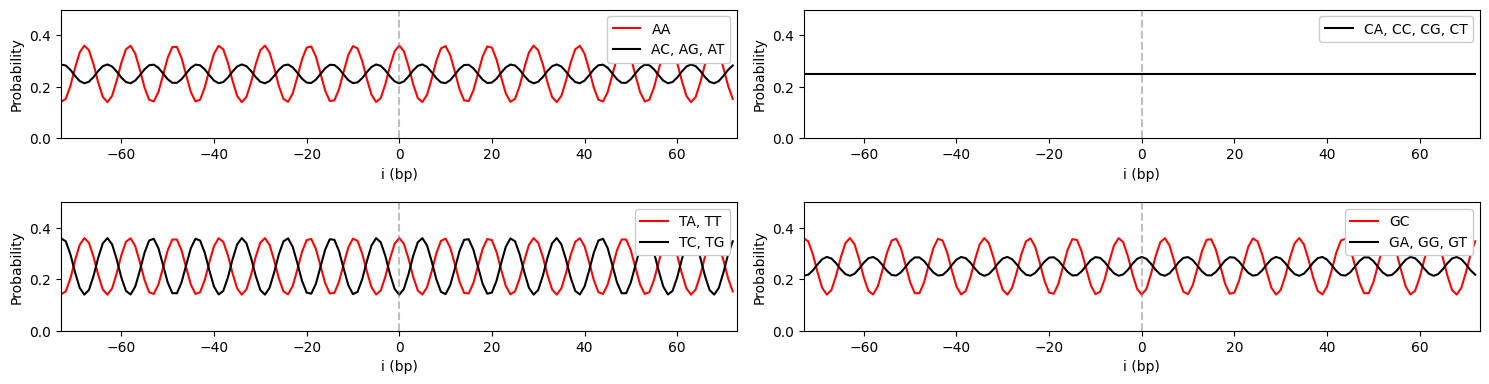

In [58]:
# compute array of position-dependent dinucleotide preferences

FOOTPRINT = 146

_ASCII_TO_IDX = np.full(256, -1, dtype=np.int8)
_ASCII_TO_IDX[ord("A")] = 0
_ASCII_TO_IDX[ord("C")] = 1
_ASCII_TO_IDX[ord("G")] = 2
_ASCII_TO_IDX[ord("T")] = 3


def encode_seq(seq: str) -> np.ndarray:
    """Convert sequence string to numeric indices for vectorized computation."""
    b = np.frombuffer(seq.encode("ascii"), dtype=np.uint8)
    return _ASCII_TO_IDX[b]


def get_weight(w: int, period: float, amplitude: float, show=False) -> np.ndarray:
    """Generate periodic dinucleotide weights to model DNA bendability."""
    x = np.arange(w, dtype=np.int32) - w // 2
    s = amplitude * np.cos(2 * np.pi * x / period)
    weight = np.empty((4, 4, w), dtype=np.float64)
    weight[0, 0] = 0.25 + s
    weight[0, 1] = 0.25 - s / 3
    weight[0, 2] = 0.25 - s / 3
    weight[0, 3] = 0.25 - s / 3
    weight[1, 0] = 0.25
    weight[1, 1] = 0.25
    weight[1, 2] = 0.25
    weight[1, 3] = 0.25
    weight[2, 0] = 0.25 + s / 3
    weight[2, 1] = 0.25 - s
    weight[2, 2] = 0.25 + s / 3
    weight[2, 3] = 0.25 + s / 3
    weight[3, 0] = 0.25 + s
    weight[3, 1] = 0.25 - s
    weight[3, 2] = 0.25 - s
    weight[3, 3] = 0.25 + s

    if show:
        fig, axes = plt.subplots(2, 2, figsize=(FIGSIZE[0], FIGSIZE[1] * 2))
        axes = axes.flatten()

        for idx, base1 in enumerate("ACTG"):
            ax = axes[idx]
            label2 = ""
            base2 = "A"
            w1 = weight[*encode_seq(base1 + base2)]
            w2 = -np.ones_like(w1)
            label1 = base1 + base2
            for base2 in "CGT":
                width = weight[*encode_seq(base1 + base2)]
                if np.array_equal(width, w1):
                    label1 += ", " + base1 + base2
                else:
                    w2 = width
                    if label2 is None:
                        label2 = base1 + base2
                    else:
                        if len(label2) > 0:
                            label2 += ", "
                        label2 += base1 + base2
            if len(label1) > len(label2):
                label1, label2 = label2, label1
                w1, w2 = w2, w1

            if w1 is not None:
                ax.plot(x, w1, color="red", label=label1)
            if w2 is not None:
                ax.plot(x, w2, color="black", label=label2)

            ax.axvline(0, color="grey", linestyle="dashed", alpha=0.5)
            ax.legend(loc="upper right", framealpha=1, facecolor="white")
            ax.set_xlabel("i (bp)")
            ax.set_ylabel("Probability")
            ax.set_ylim(0, 0.5)
            ax.set_xlim(-FOOTPRINT // 2, FOOTPRINT // 2)

    plt.tight_layout()
    plt.show()
    return weight


weight = get_weight(FOOTPRINT, period=9.7, amplitude=0.11, show=True)

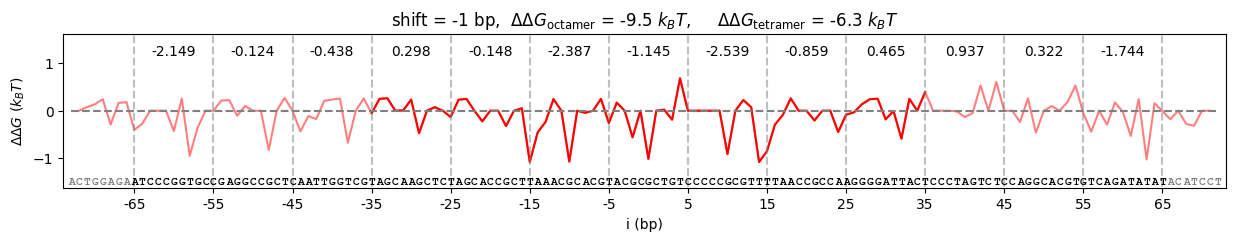

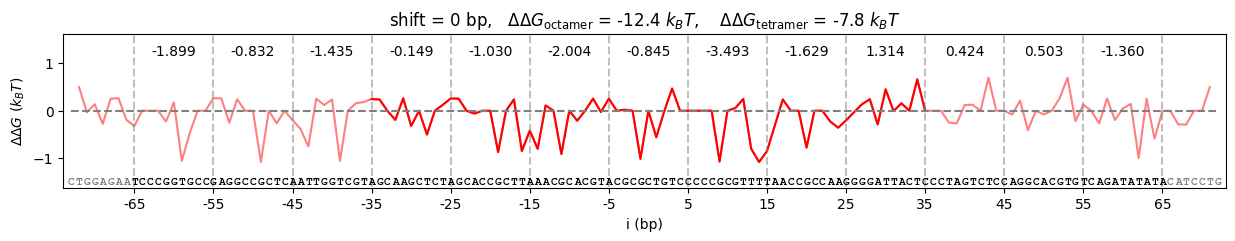

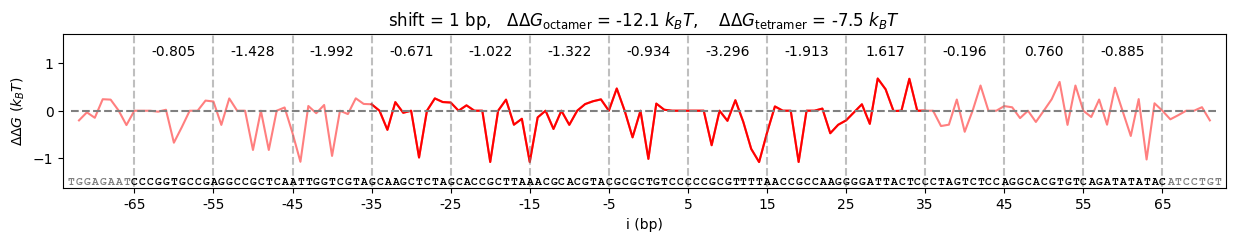

In [ ]:
# Calculate wrapping energy for a nucleosome given its sequence


@dataclass(frozen=True)
class WrappingEnergyResult:
    octamer: float
    tetramer: float
    segments: np.ndarray


def get_unwrapping_segment_positions(left=0, right=0):
    # make sure that unwrapping from the right does not include the contact points
    contacts = np.arange(-7, 7).astype(np.int16) * 10 + 5
    dyad = FOOTPRINT // 2
    segments = []
    for i in range(left):
        segments.append((contacts[i] + dyad, contacts[i + 1] + dyad))
    for i in range(right)[::-1]:
        segments.append((contacts[-(i + 2)] + dyad + 1, contacts[-(i + 1)] + dyad + 1))
    return np.asarray(segments)


def calc_wrapping_energy(sequence, dyad, log_weights, show=None):
    start = -len(log_weights[0, 0]) // 2
    end = start + len(log_weights[0, 0]) + 1
    if dyad + start < 0 or dyad + end - 1 >= len(sequence):
        return WrappingEnergyResult(
            octamer=np.nan, tetramer=np.nan, segments=np.array(np.nan)
        )

    # Extract and encode sequence segment
    seq_segment = sequence[dyad + start : dyad + end - 1]
    idx = encode_seq(seq_segment)

    # sum log-weights for both orientations as nucleosome is symmetric
    n = len(idx) - 1
    indices = np.arange(n)
    forward = log_weights[idx[:-1], idx[1:], indices] + np.log(4.0)
    forward = np.append(forward, np.nan)
    idx_rev = idx[::-1]
    reverse = log_weights[idx_rev[:-1], idx_rev[1:], indices] + np.log(4.0)
    reverse = np.append(reverse, np.nan)[::-1]
    energy = forward + reverse

    # add up energies of segments between contact points
    # make sure that segment boundaries are included for unwrapping from the outside of the octamers
    contacts = np.arange(-7, 7).astype(np.int16) * 10 + 5
    x_positions = np.arange(start, end - 1).astype(np.float64)

    tetramer = np.where((x_positions > -36) & (x_positions < 36))
    octamer = np.where((x_positions > -66) & (x_positions < 66))

    wrapping_energy = np.asarray(
        [
            np.sum(
                energy[(x_positions >= contacts[i]) & (x_positions < contacts[i + 1])]
            )
            for i in range(0, 6)
        ]
        + [np.sum(energy[(x_positions >= contacts[6]) & (x_positions <= contacts[7])])]
        + [
            np.sum(
                energy[(x_positions > contacts[i]) & (x_positions <= contacts[i + 1])]
            )
            for i in range(7, 13)
        ]
    )
    octamer_energy = np.sum(energy[octamer])
    tetramer_energy = np.sum(energy[tetramer])

    if show:
        yrange = np.nanmax(np.abs(energy))
        plt.figure(figsize=FIGSIZE)
        plt.plot(x_positions, energy, color="red", alpha=0.5)
        plt.plot(x_positions[tetramer], energy[tetramer], color="red")
        plt.hlines(
            0, x_positions[0], x_positions[-1], colors="gray", linestyles="dashed"
        )

        plt.vlines(
            contacts,
            ymin=-10,
            ymax=10,
            colors="grey",
            linestyles="dashed",
            alpha=0.5,
        )
        plt.xticks(contacts, [f"{i}" for i in contacts])
        plt.ylim(-yrange * 1.5, yrange * 1.5)
        plt.xlim(x_positions[0] - 1, x_positions[-1] + 1)

        selection = get_unwrapping_segment_positions(left=3, right=3)
        highlight = [x_positions[i] for seg in selection for i in range(seg[0], seg[1])]
        highlight = []

        for pos, base in zip(x_positions, seq_segment):
            plt.text(
                pos,
                -yrange * 1.3,
                base,
                ha="center",
                va="top",
                fontsize=8,
                family="Courier New",
                weight="bold",
                color="red" if pos in highlight else "black",
                alpha=1 if pos in x_positions[octamer] else 0.5,
            )

        for i, e in enumerate(wrapping_energy):
            pos = (contacts[i] + contacts[i + 1]) / 2
            plt.text(pos, yrange * 1.3, f"{e:.3f}", ha="center", va="top")

        plt.xlabel("i (bp)")
        plt.ylabel(r"$\Delta\Delta G$ ($k_B T$)")
        title_text = (
            rf"{show},"
            "\t"
            rf"$\Delta\Delta G_{{\mathrm{{octamer}}}}$ = {octamer_energy:.1f} $k_B T$, "
            "\t"
            rf"$\Delta\Delta G_{{\mathrm{{tetramer}}}}$ = {tetramer_energy:.1f} $k_B T$"
        )
        plt.title(title_text)
        # plt.tight_layout()
        plt.show()
    return WrappingEnergyResult(
        octamer=octamer_energy, tetramer=tetramer_energy, segments=wrapping_energy
    )


log_weights = np.log(weight)

for i in range(-1, 2):
    # for i in [0]:
    calc_wrapping_energy(
        sequence, dyads[0] + i, log_weights=log_weights, show=f"shift = {i} bp"
    )

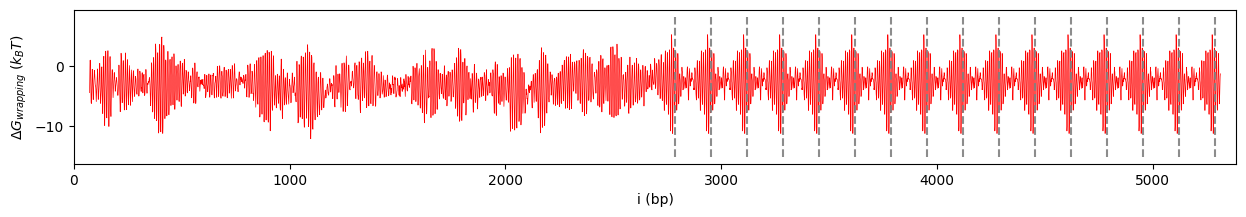

In [ ]:
# calculate wrapping energy along the entire sequence of a DNA molecule


energy = np.asarray(
    [
        calc_wrapping_energy(sequence, i, log_weights=np.log(weight)).tetramer
        for i in range(len(sequence))
    ]
)
plt.figure(figsize=FIGSIZE)
plt.plot(energy, color="red", linewidth=0.5)
plt.vlines(
    dyads,
    ymin=np.nanmin(energy) - 3,
    ymax=np.nanmax(energy) + 3,
    colors="grey",
    linestyles="dashed",
    alpha=0.9,
)
plt.xlabel("i (bp)")
plt.xlim(0, len(sequence))
plt.ylabel(r"$\Delta G_{wrapping}$ $(k_BT)$")
# plt.xlim(4000, 5000)
plt.show()

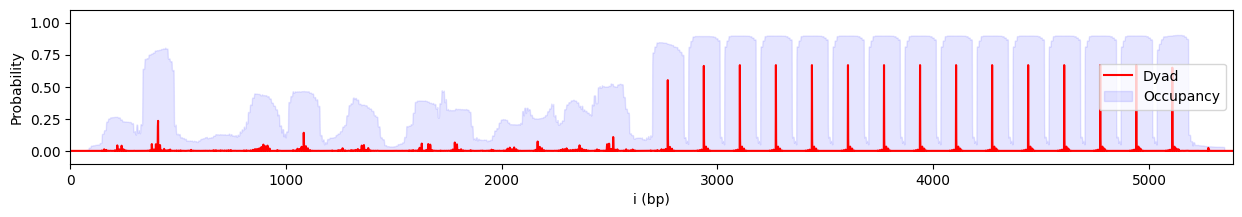

In [132]:
# Distribute nucleosomes along a sequence based on computed wrapping energies.


@dataclass(frozen=True)
class NucPositionResult:
    dyads: np.ndarray
    occupancy: np.ndarray


def compute_vanderlick(
    wrapping_energy: np.ndarray, mu: float, show=False
) -> NucPositionResult:
    """Compute equilibrium dyad probability accounting for steric exclusion between nucleosomes."""

    free_energy = wrapping_energy - mu
    # fill nans with zeros
    free_energy = np.nan_to_num(free_energy, nan=np.nanmax(free_energy))

    n = free_energy.size
    forward = np.zeros(n, dtype=np.float64)
    sum_prev = 0.0
    for i in range(n):
        forward[i] = np.exp(free_energy[i] - sum_prev)
        sum_prev += forward[i]
        if i >= FOOTPRINT:
            sum_prev -= forward[i - FOOTPRINT]
    backward = np.zeros(n, dtype=np.float64)
    r_forward = forward[::-1]
    sum_prod = 0.0
    for i in range(n):
        backward[i] = 1.0 - sum_prod
        sum_prod += r_forward[i] * backward[i]
        if i >= FOOTPRINT:
            sum_prod -= r_forward[i - FOOTPRINT] * backward[i - FOOTPRINT]
    dyads = forward * backward[::-1]
    dyads = np.clip(dyads, 0, np.inf)
    dyads[np.isnan(wrapping_energy)] = 0

    occupancy = np.convolve(dyads, np.ones(FOOTPRINT, dtype=np.float64), mode="same")
    occupancy = np.clip(occupancy, 0, 1)

    if show:
        plt.figure(figsize=FIGSIZE)
        plt.plot(dyads, label="Dyad", color="red")
        plt.fill_between(
            np.arange(len(sequence)),
            occupancy,
            label="Occupancy",
            color="blue",
            alpha=0.1,
        )
        plt.ylim(-0.10, 1.1)
        plt.xlim(0, len(sequence))
        plt.xlabel("i (bp)")
        plt.ylabel("Probability")
        plt.legend()
        plt.show()

    return NucPositionResult(dyads=dyads, occupancy=occupancy)


chemical_potential = 5.0
distribution = compute_vanderlick(energy, chemical_potential, show=True)

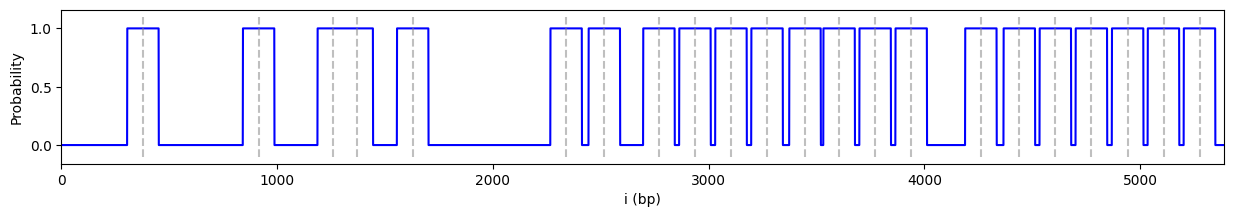

In [ ]:
# Compute distirbution by single-molecule sampling


def sample_fiber_configuration(
    dyad_probability: np.ndarray, show=False
) -> NucPositionResult:
    """
    Stochastically sample a single nucleosome arrangement to generate ensemble statistics.
    Edge regions are excluded to prevent boundary artifacts from biasing occupancy.
    """
    p = dyad_probability.copy()
    p[np.isnan(p)] = 0
    occupancy = np.zeros_like(dyad_probability)
    dyads = []

    num_nucleosomes = np.random.poisson(lam=np.sum(p))

    half_footprint = FOOTPRINT // 2
    seq_length = len(dyad_probability)

    for _ in range(int(num_nucleosomes)):
        if p.sum() < 0.5:
            break
        # Sample a dyad position
        dyads.append(np.random.choice(seq_length, p=p / p.sum()))

        nuc_start = dyads[-1] - half_footprint
        nuc_end = nuc_start + FOOTPRINT

        occupancy[nuc_start:nuc_end] = 1
        p[nuc_start:nuc_end] = 0

    dyads = np.asarray(dyads)

    if show:
        plt.figure(figsize=FIGSIZE)
        plt.plot(occupancy, label="Occupancy", color="blue")
        plt.xlim(0, len(sequence))
        plt.xlabel("i (bp)")
        plt.ylabel("Probability")
        plt.vlines(dyads, -0.1, 1.1, color="grey", linestyle="dashed", alpha=0.5)
        plt.show()

    return NucPositionResult(dyads=dyads, occupancy=occupancy)


sample_fiber_configuration(distribution.dyads, show=True)

100%|██████████| 1000/1000 [00:02<00:00, 482.40it/s]



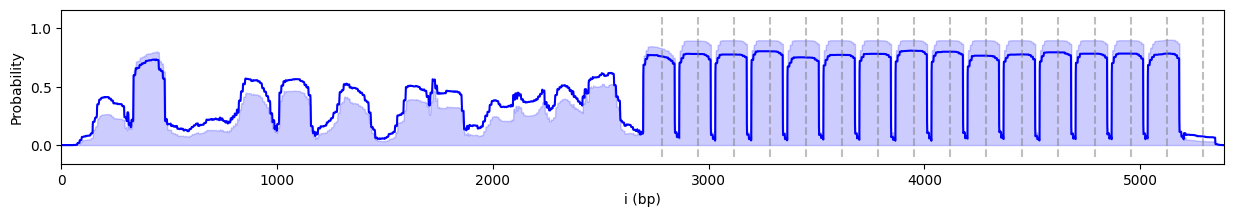

In [136]:
# Check that average over many samples recapitulates equilibrium distributions.
# However, for high densities, occupancy is underestimated due to steric exclusion.

n = 1000
mean_occupancy = np.zeros_like(distribution.occupancy)
for _ in tqdm(range(n)):
    mean_occupancy += sample_fiber_configuration(
        distribution.dyads, show=False
    ).occupancy
mean_occupancy /= n

plt.figure(figsize=FIGSIZE)
plt.plot(mean_occupancy, label="Occupancy", color="blue")
plt.fill_between(
    range(len(distribution.occupancy)),
    distribution.occupancy,
    label="Equilibrium",
    color="blue",
    alpha=0.2,
)
plt.xlim(0, len(sequence))
plt.xlabel("i (bp)")
plt.ylabel("Probability")
plt.vlines(dyads, -0.1, 1.1, color="grey", linestyle="dashed", alpha=0.5)
plt.show()

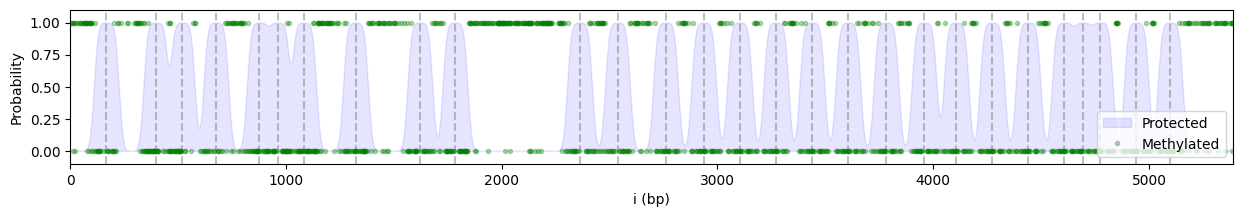

In [ ]:
def calc_methylation(
    sequence, dyads, sigma=15, motifs=["A"], strand="both", efficiency=0.85, show=False
):
    dyads = np.array(dyads)
    footprint = FOOTPRINT - 2 * sigma
    unprotected = [
        np.prod(
            0.5 * (1 + erf((np.abs(dyads - i) - footprint / 2) / (sigma * np.sqrt(2))))
        )
        for i in range(len(sequence))
    ]

    unprotected = np.asarray(unprotected)
    targets = np.zeros(len(sequence), dtype=int)

    for motif in motifs:
        offset = 1 if motif == "GC" else 0
        if strand in ["both", "forward", "+"]:
            for match in re.finditer(motif, sequence):
                targets[match.start() + offset] = 1
        if strand in ["both", "reverse", "-"]:
            rev_motif = motif[::-1].translate(str.maketrans("ACGT", "TGCA"))
            for match in re.finditer(rev_motif, sequence):
                targets[match.start() + offset] = 1

    methylated = np.random.binomial(1, unprotected * targets * efficiency).astype(float)

    # remove non-target bases from methylation array
    methylated[targets == 0] = np.nan

    if show:
        plt.figure(figsize=FIGSIZE)
        plt.fill_between(
            range(len(sequence)),
            1 - unprotected,
            color="blue",
            alpha=0.1,
            label="Protected",
        )
        plt.vlines(
            dyads, ymin=-0.1, ymax=1.1, colors="grey", linestyles="dashed", alpha=0.5
        )
        plt.plot(methylated, ".", color="green", alpha=0.3, label="Methylated")
        plt.ylim(-0.1, 1.1)
        plt.xlim(0, len(sequence))
        plt.legend(loc="lower right")
        plt.xlabel("i (bp)")
        plt.ylabel("Probability")
        plt.show()
    return methylated


fiber = sample_fiber_configuration(distribution.dyads, show=False)
methylation = calc_methylation(
    sequence,
    fiber.dyads,
    sigma=15,
    efficiency=0.85,
    motifs=["A"],
    strand="+",
    show=True,
)